In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:

def load_images_from_directory(image_dir, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Use IMREAD_COLOR
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize image to 224x224
            images.append(img.flatten())  # Flatten the image
            labels.append(1)    
    
    images = np.array(images)
    labels = np.array(labels)
    
    df = pd.DataFrame(images)
    df['label'] = labels  
    
    return df

In [14]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_reshaped = image.reshape((224, 224, 3))  # Reshape to original dimensions
        # Convert the image to grayscale for HOG
        image_gray = cv2.cvtColor(image_reshaped, cv2.COLOR_BGR2GRAY)
        features = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

In [15]:
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for image in images:
        image_reshaped = image.reshape((224, 224, 3))
        image_gray = cv2.cvtColor(image_reshaped, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        lbp = local_binary_pattern(image_gray, n_points, radius, method="uniform")  # Apply LBP
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))  # LBP histogram
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize histogram
        lbp_features.append(lbp_hist)
    return np.array(lbp_features)

In [16]:
def apply_kmeans_clustering(features, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features)
    labels = kmeans.labels_
    return labels

In [22]:
def extract_sift_features(images, n_clusters=50):
    sift = cv2.SIFT_create()
    descriptors = []

    for image in images:
        image_reshaped = image.reshape((224, 224, 3))
        gray = cv2.cvtColor(image_reshaped, cv2.COLOR_BGR2GRAY)
        keypoints, desc = sift.detectAndCompute(gray, None)
        if desc is not None:
            descriptors.append(desc)
    
    # Perform K-means clustering on all SIFT descriptors to form a visual "vocabulary"
    all_descriptors = np.vstack(descriptors)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    
    sift_features = []
    for desc in descriptors:
        hist = np.zeros(n_clusters)
        cluster_assignments = kmeans.predict(desc)
        for cluster in cluster_assignments:
            hist[cluster] += 1
        sift_features.append(hist)
    
    return np.array(sift_features)

In [18]:
def visualize_clusters(image_data, labels, num_clusters=2):
    for cluster in range(num_clusters):
        cluster_images = [image_data[i] for i in range(len(labels)) if labels[i] == cluster]
        print(f"Cluster {cluster}: {len(cluster_images)} images")
        plt.figure(figsize=(12, 6))
        for i, img_array in enumerate(cluster_images[:5]):  # Show first 5 images from each cluster
            img = img_array.reshape((224, 224, 3))  # Reshape back to original dimensions
            plt.subplot(1, 5, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Cluster {cluster}")
            plt.axis('off')
        plt.show()

Loading images from directories...
Extracting features...
Applying K-means clustering...


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Visualizing clusters...
Cluster 0: 1036 images


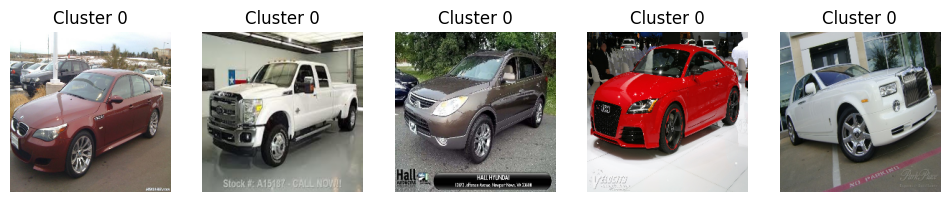

Cluster 1: 248 images


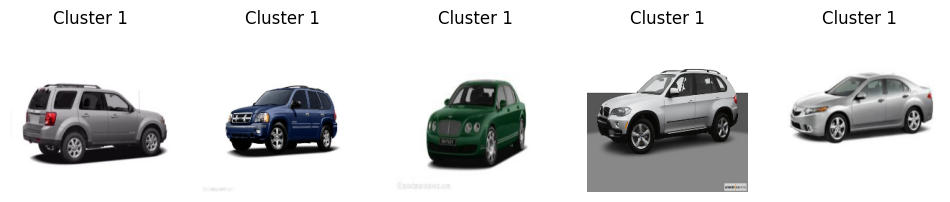

Cluster 2: 762 images


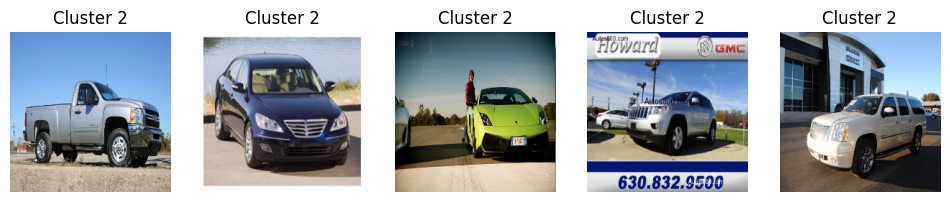

Cluster 3: 703 images


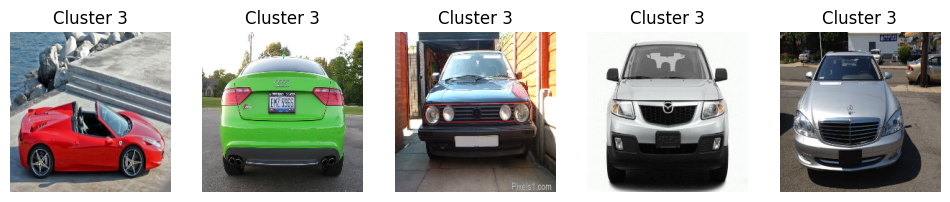

Cluster 4: 1335 images


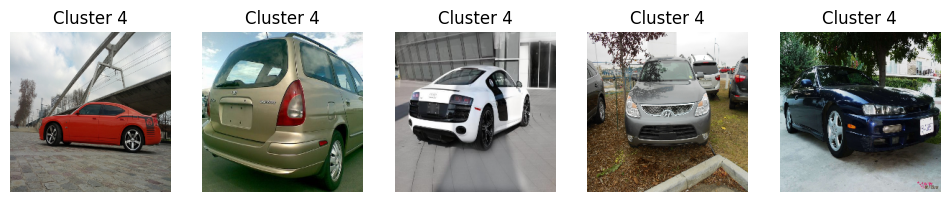

Cluster 5: 1172 images


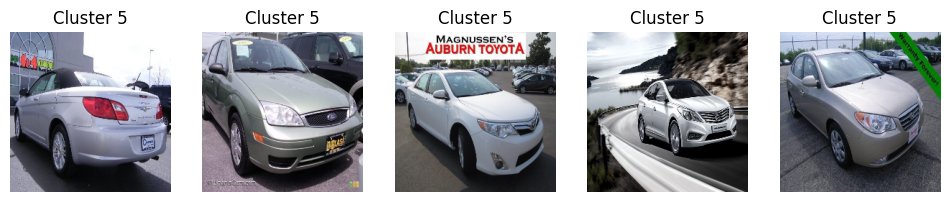

Cluster 6: 929 images


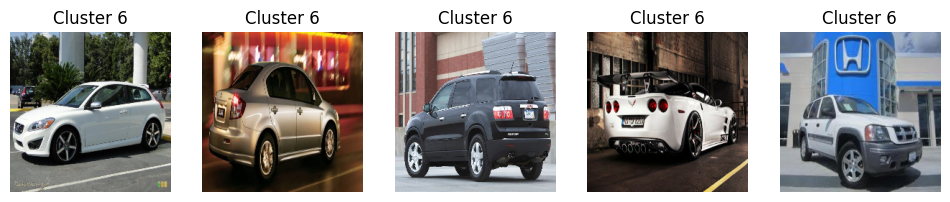

Cluster 7: 563 images


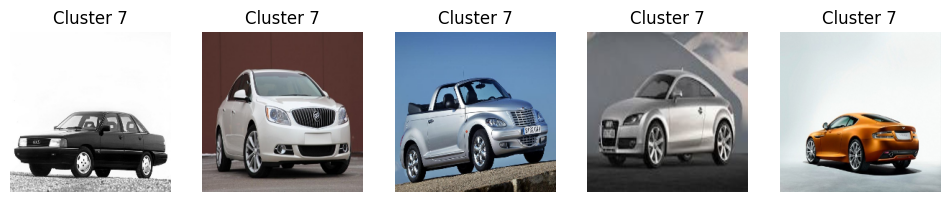

Cluster 8: 394 images


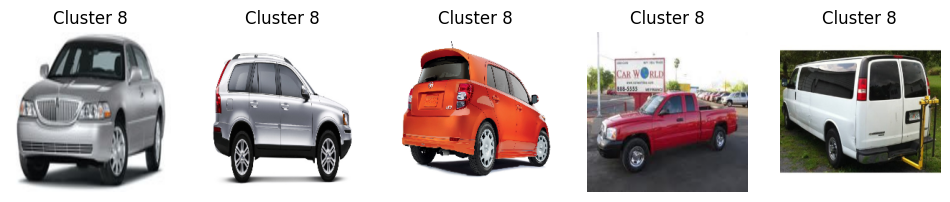

Cluster 9: 1002 images


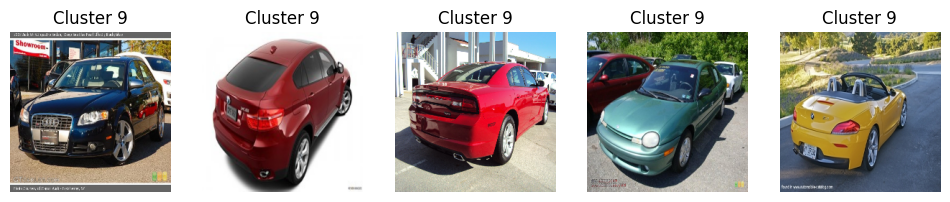

In [24]:
def main():
    image_dir = '/kaggle/input/stanford-cars-dataset/cars_train/cars_train'
    
    print("Loading images from directories...")
    df = load_images_from_directory(image_dir)

    print("Extracting features...")
    features = extract_hog_features(df.iloc[:, :-1].values)  # Exclude label column

    print("Applying K-means clustering...")
    num_clusters = 10  
    labels = apply_kmeans_clustering(features, num_clusters)

    print("Visualizing clusters...")
    visualize_clusters(df.iloc[:, :-1].values, labels, num_clusters)


if __name__ == "__main__":
    main()
